# Machine Learning Project 'Bank Marketing'

Project by Yossi Lichtenstein and Linus Wunderlich

Code based on https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb

Dataset from a Portuguese bank, based on a kaggle competition:
https://www.kaggle.com/yufengsui/portuguese-bank-marketing-data-set


Idea based on a student's project of Nisal Liyanaarachchi

## Aim:
Predict the outcome of a bank's marketing campaign based on some information collected on the customers. In particular, we wish to decide which customers to call.

# Initialisation: Import module and set random seeds

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import matplotlib.pyplot as plt

import os
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder 
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# Model evaluation und visualisation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

# Hyperparameter optimisation
from sklearn.model_selection import GridSearchCV

# to make this notebook's output stable across runs
np.random.seed(42)

# Load and investigate data

In [2]:
marketing_data = pd.read_csv("bank-downsampled.csv")

Before investigating the date, we read the description on Kaggle and the UCI Machine Learning Repository

https://www.kaggle.com/yufengsui/portuguese-bank-marketing-data-set
    
https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

Also we can use Excel to investigate the data manually

In [3]:
# Investigate data:
x = marketing_data.loc[0:5,"deposit"]
x[:] = "no"
x
marketing_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,no
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,no
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,no
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,no
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,no


We note numerical values for 

> age, balance, day, duration, campaign, pdays and previous,

and 'object' values (usually a string) for

> job, marital, education, default, loan, contact, month, poutcome and deposit

We further investigate the categories (usually booleans and objects) by looking at the value count

In [4]:
cat = ['job','marital','education','default','housing','loan','contact','contact','month','poutcome','deposit'] # can be automated
for c in cat:
    print( c, ':')
    print(marketing_data[c].value_counts() )

job :
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64
marital :
married     6351
single      3518
divorced    1293
Name: marital, dtype: int64
education :
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64
default :
no     10994
yes      168
Name: default, dtype: int64
housing :
no     5881
yes    5281
Name: housing, dtype: int64
loan :
no     9702
yes    1460
Name: loan, dtype: int64
contact :
cellular     8042
unknown      2346
telephone     774
Name: contact, dtype: int64
contact :
cellular     8042
unknown      2346
telephone     774
Name: contact, dtype: int64
month :
may    2824
aug    1519
jul    1514
jun    1222
nov     943
apr     923
feb     776
oct     392
jan     344
sep     319
mar     2

In [5]:
# We can investigate the numerals using the "describe" function
marketing_data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


## Data insights
We note that the value for "month" is unevenly distributed. Without a clear idea of its meaning, we drop it first

Also based on the description of the dataset, we decide that the duration is not suitable to predict, whether it is worth to call a certain customer.

# Clean the data

In [6]:
marketing_data = marketing_data.drop(['duration','month'], axis=1)
# when removing month from the table, we also need to drop them from the list of categorical features
cat = [item for item in cat if not ( item=='duration' or item=='month' ) ]

# Test-Train split
We avoid further investigation of the full dataset. Instead, we split the data and work on training data only

In [7]:
marketing_label = marketing_data['deposit'].copy()
marketing_features = marketing_data.drop('deposit', axis=1)

marketing_features, marketing_features_test, marketing_label, marketing_label_test \
    = train_test_split(marketing_features, marketing_label, test_size=0.2, random_state=42)

In [8]:
print(marketing_features.shape)
print(marketing_label.shape)

(8929, 14)
(8929,)


# Pre-process data:

Fill missing values for numerals

Encode categorical features

In [9]:
# Numerical and categorical features are handled differently, therefore we split them

# we get the categorical features by removing the deposit from the list of categories (as it's the label)
cat_feature_names = [item for item in cat if not ( item=='deposit' ) ]

marketing_features_num = marketing_features.drop(cat_feature_names, axis=1) 
numerical_feature_names = marketing_features_num.columns

marketing_features_cat = marketing_features[cat_feature_names]

Next, we create a class to select numerical or categorical columns. In order to handle both numerical and categorical features, We need some programming trick because Scikit-Learn does not handle DataFrames which would have made this very simple. You can ignore the details of this Jupyter cell and just use the code. However, if you wish to understand, you need to know a few things about Python Classes and about Scikit-Learn conventions.

In Python, Classes are used to bundle data and functionality together. When a class is called or initiated it creates an instance with data and functionality. Classes also inherit functionality from their base classes, as we will see below. Also, Python classes have a standard method called '__init__()' that initializes the instance state. Here, the state is the feature names, so each instance will keep the feature names that appears when the class is initiated (see the pipeline in the next cell). The word 'self' is used in Python as a shorthand for the instance of the class. So, for example, the method ‘fit()’ below just returns the instance of the class.

The DataFrameSelector class definition below follows the Scikit-Learn convention of having in each class the methods 'fit()' and 'transform()'. The class is also defined as a super-class of two Scikit-Learn classes: The BaseEstimator class provides the new class the methods 'get_params()' and 'set_params()' which may be useful later on. The TransformerMixin class provides the method 'fit_transform()' which is created from the 'fit()' and 'transform()' methods which we define.
 
Although all these definitions are complex, the class itself is simple. The method ‘fit()’ returns the instance itself, and the method 'transform()' selects the numerical  or categorical features according to the state that the instance remembers (feature_names saved as attribute_names). The instance then provides their values. 

In [10]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.attribute_names = feature_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [11]:
# counting missing values for each feature:
for i in marketing_data:
    print( i,marketing_data[i].isnull().sum() )

age 0
job 0
marital 0
education 0
default 0
balance 0
housing 0
loan 0
contact 0
day 0
campaign 0
pdays 0
previous 0
poutcome 0
deposit 0


In [12]:
# Impute fills missing numerals by the median of the remaining data
imputer = SimpleImputer(strategy="median")

# The imputer is fit on the training data. It can then also be applied to the test data (without a refit)
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(numerical_feature_names)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

# We run the pipeline to check, whether it runs with no problems
temp = num_pipeline.fit_transform(marketing_features)

In [13]:
# One-Hot-Encoder replaces categorical features by boolean features, stating whether a certain category is true or not
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_feature_names)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

# We run the pipeline to check, whether it runs with no problems
temp = cat_pipeline.fit_transform(marketing_features)

In [14]:
#Combine both imputers and get cleaned data

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
marketing_data_prepared = full_pipeline.fit_transform(marketing_features)

In [15]:
marketing_label = marketing_label.map({'yes':1, 'no':0})
marketing_label_test = marketing_label_test.map({'yes':1, 'no':0})

In [16]:
# Check the size of the data to see the amount of features
print(marketing_data_prepared.shape)

(8929, 41)


# Evaluate models

### Logistic Regression

In [17]:
logistic_regression=LogisticRegression(random_state=42, solver='liblinear')  
#Note "solver='liblinear'" was added based on a Future Warning
logistic_regression.fit(marketing_data_prepared,marketing_label)

LogisticRegression(random_state=42, solver='liblinear')

In [18]:
predictions = logistic_regression.predict(marketing_data_prepared)
mse = mean_squared_error(marketing_label, predictions)
rmse = np.sqrt(mse)
print('Mean Squared Error: ', rmse)

Mean Squared Error:  0.5654596822556774


In [19]:
coefs=logistic_regression.coef_[0]                      # coeficient from the classifier
for (a,c) in zip(numerical_feature_names,coefs):    # just the numeric; categorical needs to unpack the one hot encoding
    print('%8s: %5.4f' % (a,c) )

     age: -0.0091
 balance: 0.0875
     day: -0.0504
campaign: -0.2436
   pdays: 0.0265
previous: 0.0240


In [20]:
coefs=logistic_regression.coef_[0][7:20]
jobs=marketing_data['job'].value_counts()
#jobs.index[0]
for (ji,jv,c) in zip(jobs.index,jobs,coefs):    # one-hot-encoding for 'job'
    print('%15s (count %5d): %5.4f' % (ji,jv,c) )

     management (count  2566): -0.0424
    blue-collar (count  1944): -0.2741
     technician (count  1823): -0.2726
         admin. (count  1334): -0.1567
       services (count   923): 0.5356
        retired (count   778): -0.1444
  self-employed (count   405): -0.1045
        student (count   360): 0.4273
     unemployed (count   357): -0.0723
   entrepreneur (count   328): 0.0618
      housemaid (count   274): -0.0294
        unknown (count    70): 0.0415


Although the machine learning approach focuses on prediction and minimizing the prediction error, it is important to understand the model in the statistical inference or testing hypothesis tradition. This is important because we would need to explain the results to the business managers and showing the importance and effect of the features is part of this explanation. It may be important also because we may have defined some features incorrectly and reasoning about each feature and its effect helps to reveal such modelling errors. 

For the current dataset, it would be good to understand the coefficients of the numerical  features first. We see below that higher age and higher balance increases the probability that the customer will purchase a deposit. This makes sense. In contrast, a higher ‘campaign’ value, namely higher number of contacts performed during this campaign and for this client reduces the probability of purchase – so nagging is counter productive, at least in this context.  This non-nagging advise is confirmed by ‘pdays’ the number of days that passed by after the client was last contacted from a previous campaign which has a positive coefficient. The positive coefficient for ‘previous’ which is the number of contacts performed before this campaign and for this client is not very clear because we do not the period length for this variable, but it should be discussed when explaining the results to the business managers.

In [21]:
scores = cross_val_score(logistic_regression, marketing_data_prepared, marketing_label,
                         scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
#
def display_scores(scores):
    print('Mean:%5.4f'%scores.mean())
    print('Standard deviation:%5.4f'%scores.std())
    
display_scores(rmse_scores)

Mean:0.5695
Standard deviation:0.0114


### Decision Tree

In [22]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(marketing_data_prepared, marketing_label)

predictions = tree.predict(marketing_data_prepared)
tree_mse = mean_squared_error(marketing_label, predictions)
print('%5.4f'%tree_mse)

0.0000


In [23]:
scores = cross_val_score(tree, marketing_data_prepared, marketing_label,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [24]:
display_scores(tree_rmse_scores)

Mean:0.6290
Standard deviation:0.0094


Here we note an interesting (and very typical behaviour). The in-sample error (i.e. the error on the trainings data) is zero, while cross-validation shows significantly large error.

The reason is that the cross-validation score is computed with out-of-sample data (i.e. the error is computed on data points, which were not used within the traning). This is a typical behaviour of *overfitting*, where the decision tree simply *memorises* the data it is trained with, not yielding a better prediction.

The ability to generate a good prediction from the training is calso called *generalisation*. This topic is discussed in Week 5.

### Random Forest

In [25]:
forest = RandomForestClassifier(random_state=42, n_estimators=10)
#n_estimators=10 avoids future warning
forest.fit(marketing_data_prepared, marketing_label)

RandomForestClassifier(n_estimators=10, random_state=42)

In [26]:
predictions = forest.predict(marketing_data_prepared)
forest_mse = mean_squared_error(marketing_label, predictions)
forest_rmse = np.sqrt(forest_mse)
print('%5.4f'%forest_rmse)

0.1372


In [27]:
forest_scores = cross_val_score(forest, marketing_data_prepared, marketing_label,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Mean:0.5809
Standard deviation:0.0122


A random forest is simply a collection of decision trees, scaled independently. We see that this *ensemble* is able to provide a better prediction than a single tree. In Week 8, we will discuss ensemble learning in more detail

### Support Vector Machine

In [28]:
svm = SVC(gamma='scale') # specifying gamma avoids a FutureWarning
%time svm.fit(marketing_data_prepared, marketing_label)
predictions = svm.predict(marketing_data_prepared)
svm_mse = mean_squared_error(marketing_label, predictions)
svm_rmse = np.sqrt(svm_mse)
print('%5.4f'%svm_rmse)

Wall time: 3.95 s
0.5341


In [29]:
%time svm_scores = cross_val_score(svm, marketing_data_prepared, marketing_label, scoring="neg_mean_squared_error", cv=5)
svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Wall time: 15 s
Mean:0.5543
Standard deviation:0.0056


**Trying different hyperparameters**

In [42]:
from sklearn.base import clone
C_list = [100, 0.01]
svm_models = [clone(svm) for _ in C_list]
for C, model in zip(C_list, svm_models):
    model.set_params(C=C)
    model.fit(marketing_data_prepared, marketing_label)
    predictions = model.predict(marketing_data_prepared)
    svm_rmse = mean_squared_error(marketing_label, predictions, squared=False)
    print("\n C={0}\n All training set RMSE: {1}\n Cross_validation RMSE".format(C, svm_rmse))
    svm_scores = cross_val_score(model, marketing_data_prepared, marketing_label,
                                        scoring="neg_mean_squared_error", cv=5)
    display_scores(np.sqrt(-svm_scores))    


 C=100
 All training set RMSE: 0.39906936200982235
 Cross_validation RMSE
Mean:0.5932
Standard deviation:0.0064

 C=0.01
 All training set RMSE: 0.5807028617468191
 Cross_validation RMSE
Mean:0.5867
Standard deviation:0.0125


We note the smallest mean squared error for all methods considered. Therefore, we choose to use SVM as our final predictor. Before this, we try to optimise the SVM by performing a *hyper-parameter optimisation*. We'll discuss this further in Meeting 12.

### Hyper-parameter optimisation (may take some minutes to run)

In [31]:
param_grid = [
    # try 9 (3×3) combinations of hyperparameters
    {'C': [.1, 1., 10.], 'kernel': ['linear', 'rbf', 'sigmoid']},
    # then try 9 (3×3) combinations for a polynomial kernel
    {'kernel': ['poly'], 'C': [.1, 2., 10.], 'degree': [1, 2, 4]},
  ] # in total 9+9=18 combinations are run

svm = SVC(gamma='scale')
# train across 3 folds, that's a total of 18*3=54 rounds of training 
grid_search = GridSearchCV(svm, param_grid, cv=3,
                           scoring='neg_mean_squared_error', return_train_score=True)
%time grid_search.fit(marketing_data_prepared, marketing_label)

Wall time: 3min 10s


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf', 'sigmoid']}, {'kernel': ['poly'], 'C': [0.1, 2.0, 10.0], 'degree': [1, 2, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [32]:
grid_search.best_params_ 

{'C': 0.1, 'degree': 2, 'kernel': 'poly'}

In [33]:
grid_search.best_estimator_

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Evaluation of the final model

In [34]:
final_model = grid_search.best_estimator_


marketing_features_test_prepared = full_pipeline.transform(marketing_features_test)
final_predictions = final_model.predict(marketing_features_test_prepared)


final_mse = mean_squared_error(marketing_label_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print('%5.4f'%final_rmse)

0.5465


## Confusion Matrix & different error types

In [35]:
conf_mat = confusion_matrix(marketing_label_test, final_predictions)
print(conf_mat)

[[956 210]
 [457 610]]


In [36]:
conf_mat_normalised = conf_mat / conf_mat.sum(axis=1)

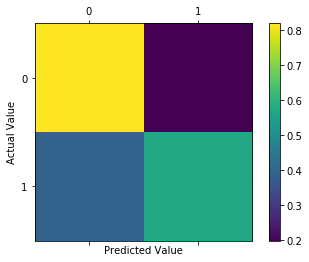

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_normalised)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
fig.colorbar(cax)

# Some notes: 
# To highlight the off-diagonal values, replace the matrix by
#  onf_mat_normalised - np.diag(np.diag(conf_mat_normalised))
# When a gray-scale image is required add
#  cmap='gray'
# to the arguments of ax.matshow

## ROC Curve

In [38]:
final_model.probability = True
# New fit, to compute scores:
final_model.fit(marketing_data_prepared, marketing_label)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

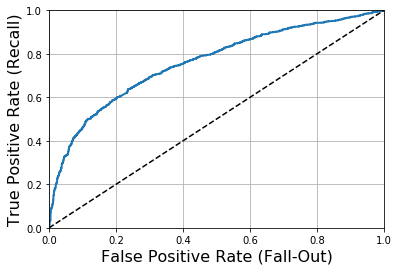

In [39]:
final_predictions_scores = final_model.predict_proba(marketing_features_test_prepared)[:,1]
fpr, tpr, thresholds = roc_curve(marketing_label_test, final_predictions_scores)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.grid(True)

## Precision and Recall

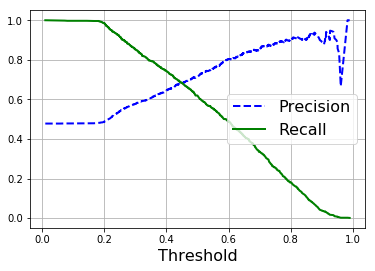

In [40]:
precisions, recalls, thresholds = precision_recall_curve(marketing_label_test, final_predictions_scores)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="center right", fontsize=16)
plt.xlabel("Threshold", fontsize=16) 
plt.grid(True)

plt.show()

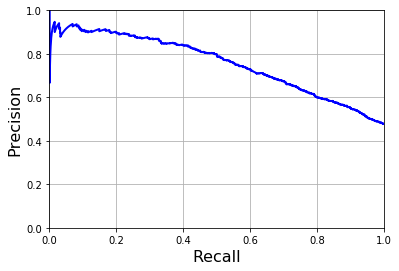

In [41]:
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

# Evaluate Business Case:

### Idea
1 person on the phone, 1 week for the campaign. Customer list made up by the 2233 items of the test set

Estimation: 10min per call (includes preparation), 8hrs per day -> 240 customers can be called

### Business decision

Call the customers with the highest probability score

In [42]:
costumer_predictions = final_predictions_scores
costumer_actual_choice = marketing_label_test.values

In [43]:
# Sort the customers in descending order by their score
index_sort = np.argsort(costumer_predictions)[::-1]
# Note: np.argsort sorts ascending. By inverting the order [::-1], we get a descending order

predictions_sorted = costumer_predictions[index_sort]

In [44]:
customers_sorted = costumer_actual_choice[index_sort]

In [45]:
# The customers are now sorted with ascending probability to deposit. 
#  Hence, we will contact the last 240 customers of the list
print('Customers score')
print(predictions_sorted[:240])
print('')
print('Customers actual choice (1 is a success, 0 is unsuccessful):')
outcome_called_customers = customers_sorted[:240]
print(outcome_called_customers)
# the index of these customers can be found in index_sort

Customers score
[0.99025294 0.98345383 0.96151924 0.95900919 0.9572509  0.95628725
 0.95145627 0.95106396 0.95097529 0.94720085 0.94141323 0.94099662
 0.94042798 0.9403448  0.93992241 0.9387978  0.93811855 0.9336698
 0.92712257 0.92636143 0.92533505 0.92447339 0.92439596 0.92398535
 0.92221603 0.92192614 0.91986297 0.91964376 0.91959453 0.91818464
 0.91653457 0.9154344  0.91520481 0.91439168 0.91371129 0.91303578
 0.91291421 0.911507   0.91104981 0.91080063 0.90763035 0.90704783
 0.9053127  0.90249946 0.90238871 0.90020015 0.89959293 0.8977321
 0.8956381  0.89393401 0.89376367 0.89314408 0.89252889 0.89243422
 0.89166876 0.89090001 0.89061557 0.89021475 0.8891875  0.88875012
 0.88863081 0.88810667 0.88776488 0.88755    0.88708415 0.88560484
 0.88527038 0.88439319 0.88315613 0.88283424 0.8823555  0.88166455
 0.88162105 0.88082268 0.87996365 0.87936508 0.87788819 0.87775924
 0.87709743 0.87700662 0.87646616 0.87610596 0.87532443 0.87518573
 0.87513494 0.87344111 0.87253041 0.87146899 0.8

In [46]:
print('Out of 240 customers, {} have deposited money'.format(sum(outcome_called_customers)))

Out of 240 customers, 215 have deposited money


To interpret the result, we need to compare the result of the prediction with the status quo, i.e. the expected outcome without any data analysis. In this case, we would have called 240 random customers. Let's compare

In [47]:
#240 random customers:
np.random.seed(142)
random_values = np.random.permutation(len(costumer_actual_choice))
customers_random = costumer_actual_choice[random_values]

print('Customers actual choice (1 is a success, 0 is unsuccessful):')
outcome_randomly_called_customers = customers_random[:240]
print(outcome_randomly_called_customers)

Customers actual choice (1 is a success, 0 is unsuccessful):
[1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0
 0 1 0 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1
 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 1 0 1 1
 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1
 1 0 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 1 0
 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 1
 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0]


In [48]:
print('Without the data analysis, out of 240 customers, {} have deposited money'.
      format(sum(outcome_randomly_called_customers)))

Without the data analysis, out of 240 customers, 123 have deposited money


## Interpretation

This shows the full effect of the data analysis. Instead of 123 customers, 214 would deposit based on our analysis. These are 91 extra customers and an increase of over 70%